In [1]:
#importing packages

import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import scipy as sp
import random

from scipy import signal

Synthetic data generation is a common method in computational neuroscience. In general, synthetic data generation strength is that it enables researchers to develop a robust algorithmic solution for solving a specific problem. Generating synthetic data is mostly a bottom-up process, whereas data analysis is a top-down process. Given the nature of synthetic data, even if the analysing algorithm is not sufficient, there will always be a room for manipulating and deconstructing the data in order to understrand the potential weaknesses of our analysing tools then improve them, which is clearly not the with real world data. Nonetheless, instantly analysing a real world data set can also lead us satisfying conclusions, a well developed algorithm can be later modified on real data so the potential risk of having false conclusions is less higher.

Based on this idea, the synthetic data generation starts with the bottom element or the primal focus of the research, which are independent dendritic events in this case. As it is stated above, the neuronal recording of the CA3 neurons catch the cell activity marked by the fluorescent liquid. To simulate this, first I generate synthetic somatic (A and B soma) and dendritic (dendrite of A soma) spike trains then convolve it. Secondary, I create rectangles that attempts to simulate a low resolution frame of recording a soma, its dendrites and a second soma whichs to some extent overlaps the dendrite. Lastly, taking the outer product of the spike trains and the frames leads us to a neuronal record simulation. To specify this, I in the following section I would like to indtroduce the generated data for my research.

## Spike trains

For neural spike generation I implement a randomized poission process. Poission process consists of events within a specific time frequency. On real neural recordings we observed relatively low frequency activity, therefore I have defined fr_Soma = 0.2 for soma A and fr_Dendrite = fr / 0.5 spike frequency in an 15 mins sequence (with 1/30 number of bins - dt), which results at the total of 27000 timebins (nBins). To randomize the events this, I use np.random.rand() function from the Numpy package. This function generates random integers in the specified time range (nBins) and we can specifiy the events in time by defining the largest number (fr_Soma or fr_Dendrite multyplied by dt) that the function can return below.

27000

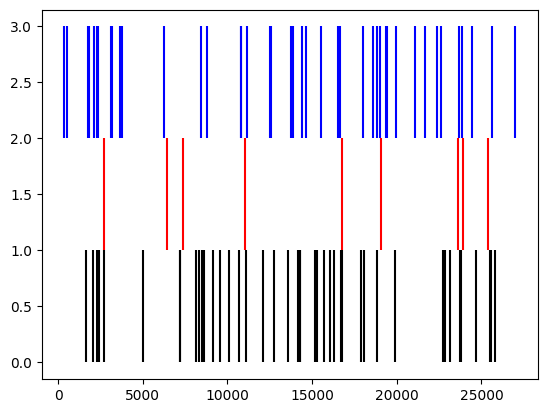

In [2]:
np.random.seed(500)

fr = 0.05 # frequency
fr_2 = fr/5 # frequency
dt = 1/30.0; # s
Tmax = 900 # s
t = np.arange(0, Tmax, dt)
nBins = np.round(Tmax / dt).astype(int) # 5 min spike train
nTrials = 1; # Number of trials
myPoissonSpikeTrain_1 = np.random.rand(1,nBins) < fr*dt; # Poisson spike train built by logical values
spikes_a = myPoissonSpikeTrain_1.flatten()*1 # convert to np.array

myPoissonSpikeTrain_2 = np.random.rand(1,nBins) < fr_2*dt; # Poission spike train built by logical values
spikes_a_dend = myPoissonSpikeTrain_2.flatten()*1 # convert to np.array

myPoissonSpikeTrain_3 = np.random.rand(1,nBins) < fr*dt; # Poission spike train built by logical values
spikes_b = myPoissonSpikeTrain_3.flatten()*1 # convert to np.array

plt.vlines(np.flatnonzero(spikes_a), 0, 1, 'k')
plt.vlines(np.flatnonzero(spikes_a_dend), 1, 2, 'r')
plt.vlines(np.flatnonzero(spikes_b), 2, 3, 'b')
len(t)

For simulating the time consuming process wherein fluorescent fluid carried CA2+ molecules flows out to the extracellular space, I have to add realistic decays to the neural spikes. To implement this, I define the following convolutional kernel: exp(time/tau) - tau = 2, time = 300. For convolution mode I used valid mode, since keeping the initial dimenions are not important. After tthe convolution we use the results as synthetic fluorescent signals.

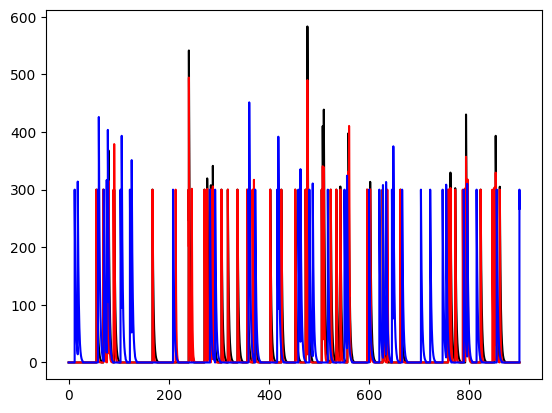

In [3]:
#causal_conv_ker ?

tt = np.arange(300) / 30.0
tau_soma = 2
convker_soma = np.exp(-tt/tau_soma)
tau_dend = 1
convker_dend = np.exp(-tt/tau_dend)

dF_a_soma = np.convolve(np.hstack((np.zeros(299), spikes_a)), convker_soma, mode='valid') * 300 
dF_a_dend = np.convolve(np.hstack((np.zeros(299), spikes_a+spikes_a_dend)), convker_dend, mode='valid') * 300
dF_b_soma = np.convolve(np.hstack((np.zeros(299), spikes_b)), convker_soma, mode='valid') * 300

plt.plot(t, dF_a_soma, '-k')
plt.plot(t, dF_a_dend, '-r')
plt.plot(t, dF_b_soma, '-b')

#plt.xlim(0, 50)


Next, I generate 36 pixel large rectangles (40x40 for somas, 20x50 for the dendrite) inside a 100x100 shape pictures.

## Generated images

In [4]:
x_1 = np.zeros(100)
x_1[10:50] = 1
y_1 = np.zeros(100)
y_1[10:50] = 1

x_2 = np.zeros(100)
x_2[45:95] = 1
y_2 = np.zeros(100)
y_2[20:40] = 1

x_3 = np.zeros(100)
x_3[53:93] = 1
y_3 = np.zeros(100)
y_3[35:74] = 1

In [5]:
a_soma = np.outer(x_1,y_1)
dendrites = np.outer(x_2,y_2)
b_soma = np.outer(x_3,y_3)

masks = a_soma + 2*dendrites + 4*b_soma

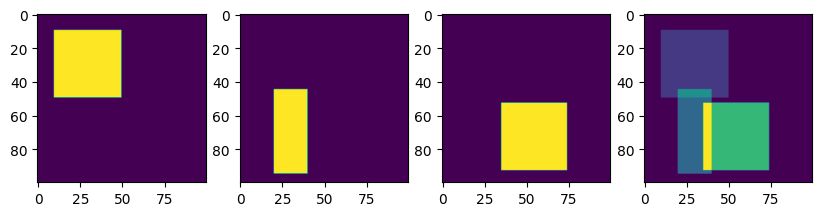

In [6]:
fig = plt.figure(figsize=(10, 10))

rows = 1
columns = 4

#1
fig.add_subplot(rows, columns, 1)
plt.imshow(a_soma)

#2
fig.add_subplot(rows, columns, 2)
plt.imshow(dendrites)

#3
fig.add_subplot(rows, columns, 3)
plt.imshow(b_soma)

fig.add_subplot(rows, columns, 4)
plt.imshow(masks)

masks = np.save('masks', masks)

For having a realistic neuronal sequence we have to take the outer product of the signals and the generated pictures, which results in three 2700x200 matrices.

## Synthetic frames

In [7]:
a_soma_flat = a_soma.flatten()*1
dendrites_flat = dendrites.flatten()*1
b_soma_flat = b_soma.flatten()*1

a_soma_frames = np.outer(a_soma_flat, dF_a_soma)
dendrites_frames = np.outer(dendrites_flat, dF_a_dend)
b_soma_frames = np.outer(b_soma_flat, dF_b_soma)

(0.0, 27000.0)

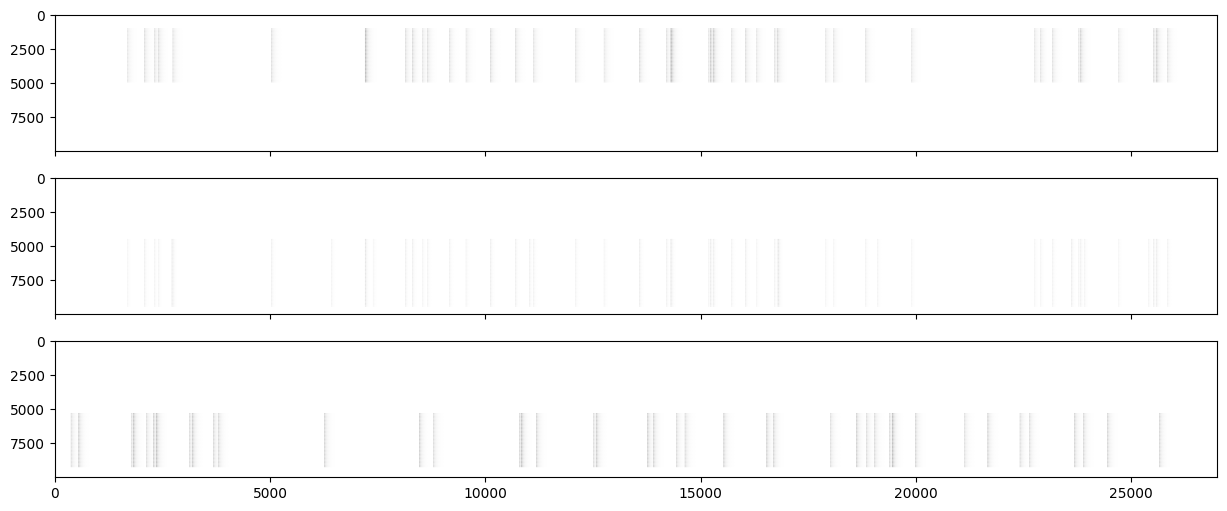

In [8]:
f, axs = plt.subplots(3, 1, sharex=True, figsize=(15, 6))

#1
axs[0].imshow(a_soma_frames[:,:], cmap='Greys', aspect = 'auto')
axs[0].set_xlim(0, 27000)

#2
axs[1].imshow(dendrites_frames[:,:], cmap='Greys', aspect = 'auto')
axs[1].set_xlim(0, 27000)

#3
axs[2].imshow(b_soma_frames[:,:], cmap='Greys', aspect = 'auto')
axs[2].set_xlim(0, 27000)

I add realistic noise to the signals by using the paramteres (location/mean = 750, sigma/standard deviation = 20) extracted by the noise analysis and recreate it by np.random.normal fucntion that calls a normal distribution of random numbers given the latter paramteres. After this, I concetanate the matrices into one 1500x40 size matrix.

In [9]:
real_like_noise = np.random.normal(loc=750, scale=22, size = (10000, nBins))

In order to have a full 3D data, the reshape of 1500x40 size matrix to 1500x20x20 tensor is required.

In [10]:
dF0 = a_soma_frames  + dendrites_frames + b_soma_frames + real_like_noise # add the matrices + add noise
dF = dF0.reshape((100,100,27000))

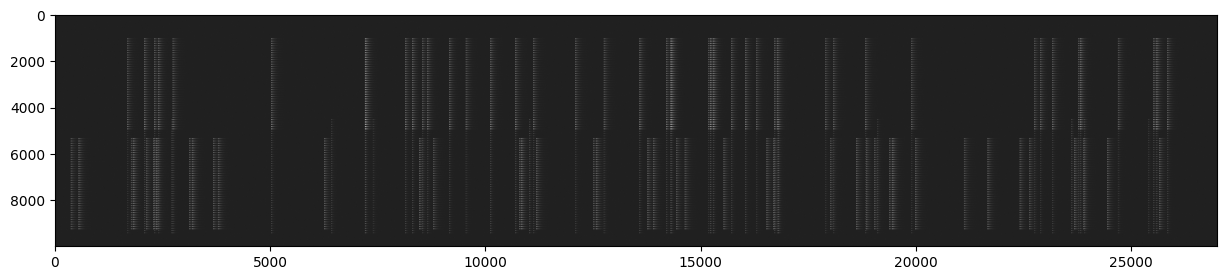

In [11]:
f, axs = plt.subplots(1, 1, sharex=True, figsize=(15, 3))
axs.imshow((dF0[:,:]+1), cmap='Greys_r', aspect = 'auto')

In the following section I would like to introduce that data analysis method that was built and optimized on the previous dataset. The method has three major parts. In the first part I define the mask coordinate of the region of interest, which for simplicity, are the coordinates of the synthetic somas and dendrites. In the second part, I use the masks to extract the fluorescent signals then filter the signals with convolving them by a moving Gauss-window - theoretically the more we increase the value of sigma the more high frequency signal ranges can be filtered out, which results in smoothened signal with less high  noise fluctuations (noise tipically exist in high frequency ranges). Finally, in the last part I developed a simple event detection function that detects the events above a specific threshold (theta_upper) and refracterize remaining part of the signal array until it reaches a secondary threshold (theta_lower), which is set below the signal orginal signal detector. 

## Masks on synthetic data:

# New mask coordinates with less overlap

a_soma_mask = np.array([[6,6],[6,7],[6,8],[6,9],
                        [7,6],[7,7],[7,8],[7,9],
                        [8,6],[8,7],[8,8],[8,9],
                        [9,6],[9,7],[9,8],[9,9],
                        [10,6],[10,7],[10,8],[10,9]])

a_dend_mask  = np.array([[10,5],[10,6],[10,7],[10,8],[10,9],[10,10],
                         [11,5],[11,6],[11,7],[11,8],[11,10],[11,10],
                         [12,5],[12,6],[12,7],[12,8],[12,9],[12,10]])

b_soma_mask  = np.array([[11,13],[11,14],[11,15],[11,16],
                         [12,13],[12,14],[12,15],[12,16],
                         [13,13],[13,14],[13,15],[13,16],
                         [14,13],[14,14],[14,15],[14,16],
                         [15,13],[15,14],[15,15],[15,16]])

In [12]:
#orginial mask coordinates

a_soma_mask = np.asarray(np.where(a_soma == 1))

a_dend_mask = np.asarray(np.where(dendrites == 1))

b_soma_mask = np.asarray(np.where(b_soma == 1))

In [13]:
#a_soma_mask_list = a_soma_mask.tolist()
#a_dend_mask_list = a_dend_mask.tolist()
#b_soma_mask_list = b_soma_mask.tolist()

synthetic_roi_masks = [a_soma_mask, a_dend_mask, b_soma_mask]

## DF on synthetic data

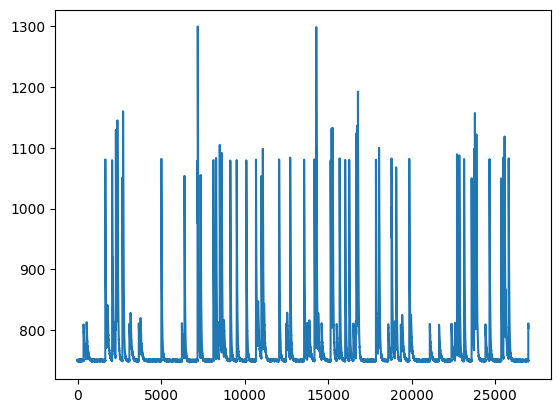

In [14]:
i_mask = 1
mask = synthetic_roi_masks[i_mask]
L_mask = mask.shape[1]
signal = np.zeros(dF.shape[2])
for i_pixel in np.arange(L_mask):
    pix = mask[:,i_pixel]
    signal = signal + dF[pix[0], pix[1],:]
signal = signal / L_mask
plt.plot(signal)

## Measuring baseline fluctuation

In [15]:
print(np.std(signal[400:500]))

7.116225121181884


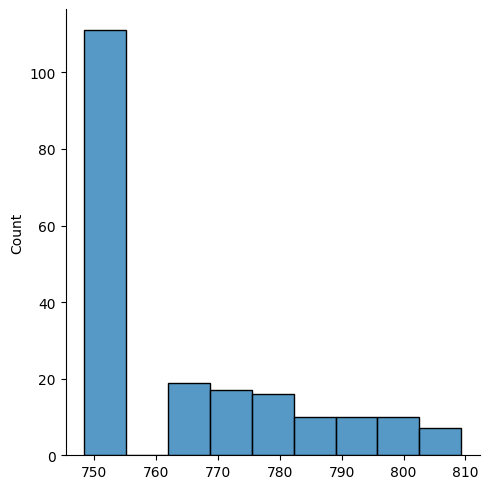

In [16]:
import seaborn as sns

sns.displot(signal[250:450])

## DFpF continue

For extracting the fluorescent signals, in the first part, an empty tensor with the shape of the original array (27000x100x100) is created where the masks are placed identically to the original data tensor and has been filled up with the original signals. Theoretically, by using the overlaping masks it should return the noise contaminated signals of the somas and dendrites which latter one is also contaminated by the acitivity of the somas. In the second part, the signals has to be divided by their median value to set them on the same baseline (DFpF) and also their maximum has to be subtracted from one in order to standardize their amplitude value.

In [17]:
def ROI_std(mask_number):
    mask_array  = synthetic_roi_masks.copy()
    j_mask = mask_number
    mask_ = mask_array[j_mask]
    L_mask_ = mask_.shape[1]
    signal_ = np.zeros(dF.shape[2])
    for j_pixel in np.arange(L_mask_):
        pix_ = mask_[:,j_pixel]
        signal_ = signal_ + dF[pix_[0], pix_[1],:]
    signal_ = signal_ / L_mask_
    DFpF = signal_ / np.median(signal_)
    ampl = max(DFpF) - 1
    return DFpF, ampl, np.std(DFpF)

In [18]:
sigs = []
SDs = np.zeros(3)
for i in range(3):
    sig, ampl_sig, SD_sig = ROI_std(i)
    SDs[i] = SD_sig # SD_sig
    sigs.append(sig)

In [19]:
print(SDs)

[0.09344047 0.07895207 0.08467014]


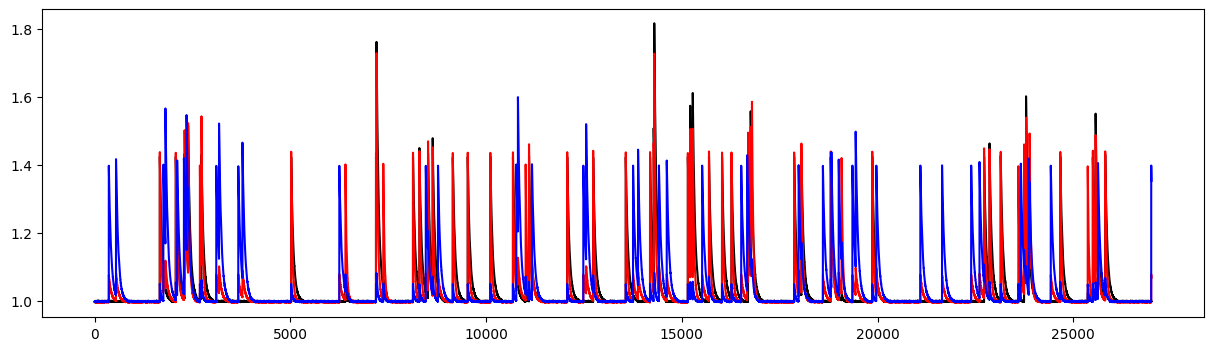

In [20]:
fig0, ax0 = plt.subplots(figsize=(15,4))

colors = ['k','r','b']
for i in range(3):
    ax0.plot(sigs[i][0:27000], color=colors[i])

## Gauss smoothing

In order to keep the original shape of the signals I needed to implement a function that adds the first and the last values of the original data array to the begining and to the end of the array in a range that is always the half and minus 1 long to a given N (odd) length convolution kernel. 

In [21]:
# function for replacing the first five and last five values of the array with 5th and the 1495th value

# convolving kernel supposed to have the target data point at the middle

def prepare_for_conv(signal_for_gauss, kernel_length):
    N = len(signal_for_gauss)
    if (kernel_length % 2) == 0:
        return ('Kernel length is even.')
    K = int((kernel_length - 1)/2) # must be even in order to have the target data point at the middle
    empty = np.zeros(N + 2*K) 
    signal_start = signal_for_gauss[0]
    signal_end = signal_for_gauss[-1]
    empty[0:K] =  signal_start
    empty[-K:] = signal_end
    empty[K:(N+K)] = signal_for_gauss
    return empty

In [22]:
signal1 = prepare_for_conv(sigs[0], 15)
signal2 = prepare_for_conv(sigs[1], 15)
signal3 = prepare_for_conv(sigs[2], 15)

Defining a 15 length Gauss kernel. 

Gauss-kernel: 

\begin{align}
        g(x) = \frac{1}{\sqrt{2\pi\sigma}} * exp^{-x^2/(2\sigma^2)}
    \end{align}

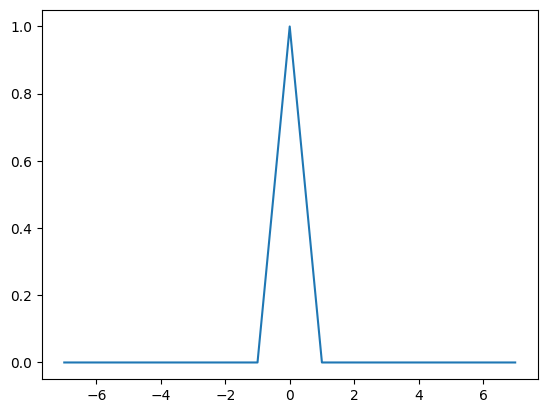

In [23]:
# 16 long gauss convolutional kernel

x = np.arange(-7,8,1)
sigma = 0.2
normal = 1 / (2.0 * np.pi * sigma**2)
gauss_kernel_beta =  np.exp(-((x**2) / (2.0*sigma**2))) * normal
gauss_kernel = gauss_kernel_beta / np.sum(gauss_kernel_beta)
plt.plot(x,gauss_kernel)

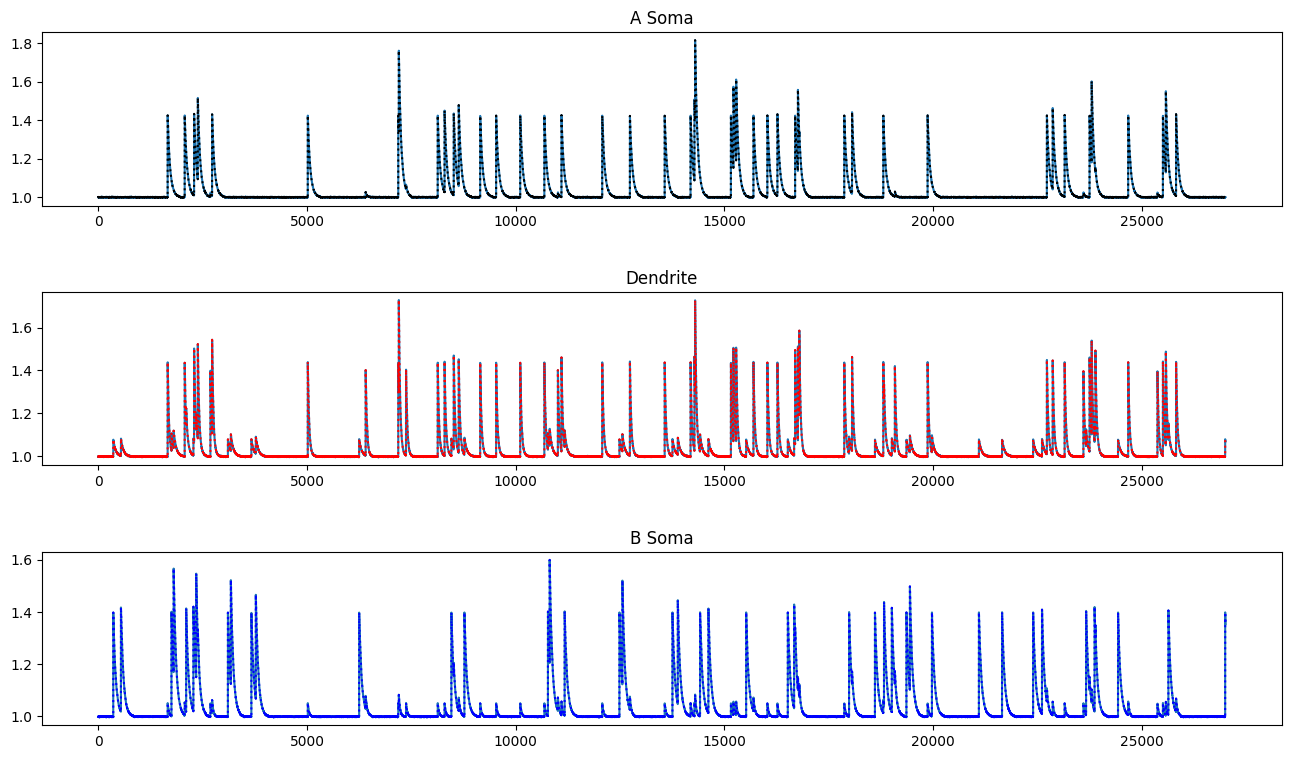

In [24]:
# plotting the gauss smoothed signals

a_events_smooth = np.convolve(signal1,gauss_kernel, mode='valid')
dendritic_events_smooth = np.convolve(signal2,gauss_kernel, mode='valid')
b_events_smooth = np.convolve(signal3,gauss_kernel, mode='valid')

fig, axs = plt.subplots(3, 1,figsize=(16,9))
plt.subplots_adjust(hspace=0.5)

axs[0].plot(sigs[0])
axs[0].plot(a_events_smooth, ':k')
axs[1].plot(sigs[1])
axs[1].plot(dendritic_events_smooth, ':r')
axs[2].plot(sigs[2])
axs[2].plot(b_events_smooth, ':b')
axs[0].title.set_text('A Soma')
axs[1].title.set_text('Dendrite')
axs[2].title.set_text('B Soma')

## Event detection

Event detection function that detects the events above a specific threshold (theta_upper) and assign a decay period to it, which is remaining part of the signal array until it reaches a secondary threshold (theta_lower). Theta lower is set below the signal orginal signal detector. The function uses a simple way to detect specific events: When the signal reaches the threshold, the function observes whether the N-1th element is lower then the event threshold and the Nth element is higher, so it returns TRUE. If this is not the signal must not be detected so signal did not go above theta_upper, however it did not go above theta_lower, whihc means it is stll a decay period and rmust return FALSE.

In [25]:
#contains an indented block

def event_detector(signal, theta_upper = 1.2, theta_lower = 1.1): 
    
    N = len(signal)
    
    event = np.zeros(N)
    
    refr = 1
    
    for i in np.arange(1,N):
        if ((signal[i] > theta_upper) and (signal[i-1] < theta_upper) and (refr == 0)):
            event[i] = 1 
            refr = 1
        if (signal[i]<theta_lower):
            refr = 0  
            
    return event

In [26]:
sig1_event = event_detector(a_events_smooth)
sig2_event = event_detector(dendritic_events_smooth, 1.05, 1)
sig3_event = event_detector(b_events_smooth, 1.05, 1)

In [27]:
t_new = len(sig1_event)
time_unit = (Tmax/nBins)*t_new*1000 # approx. 33 msec/timebin
msec = np.linspace(0,time_unit,t_new)

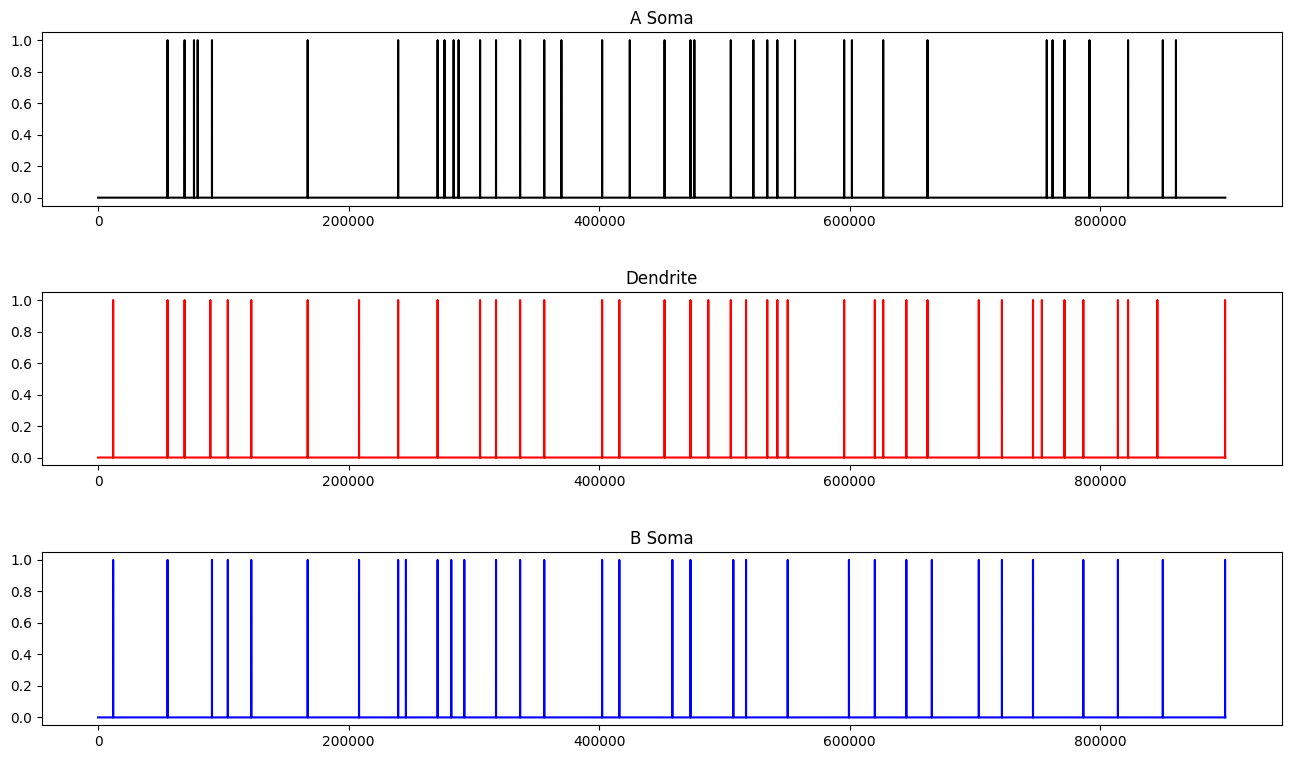

In [28]:
fig, axs = plt.subplots(3, 1,figsize=(16,9))
plt.subplots_adjust(hspace=0.5)

x = msec

axs[0].plot(x,sig1_event, color='k')
axs[1].plot(x,sig2_event, color='r')
axs[2].plot(x,sig3_event, color='b')
axs[0].title.set_text('A Soma')
axs[1].title.set_text('Dendrite')
axs[2].title.set_text('B Soma')

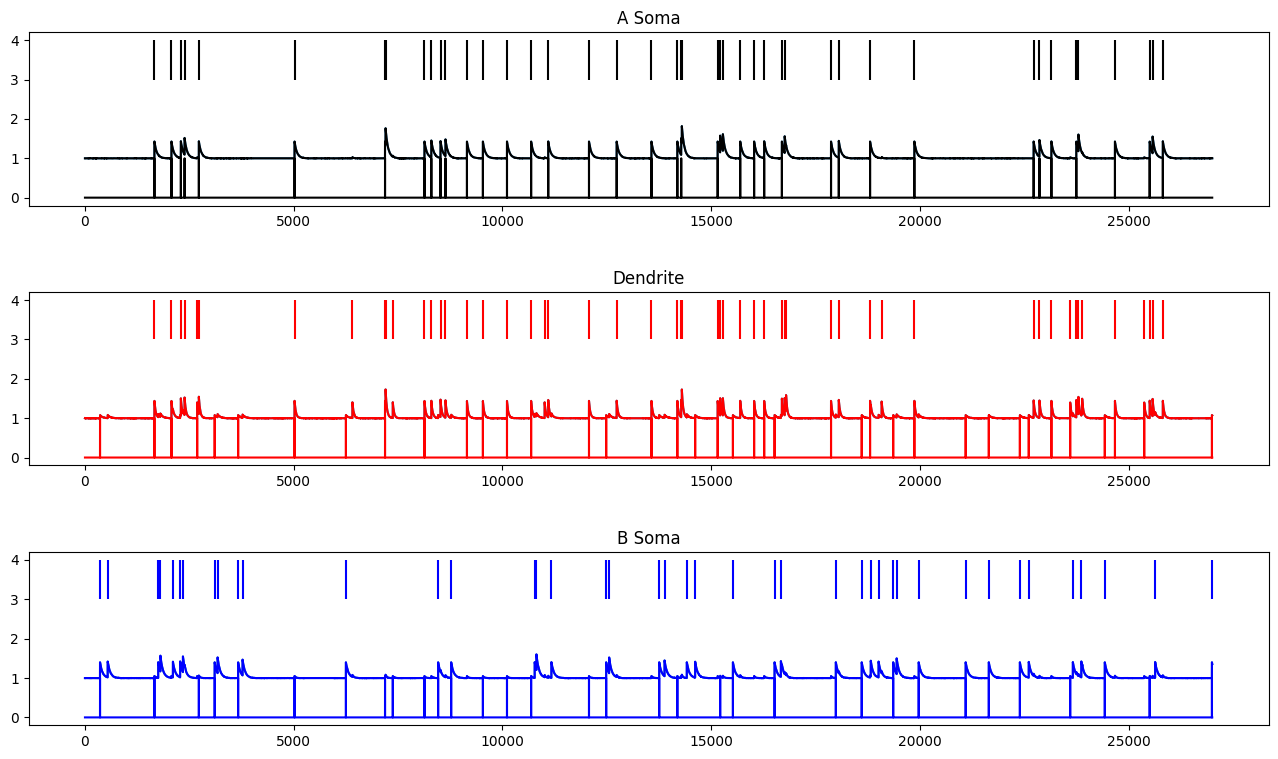

In [29]:
#%matplotlib
fig, axs = plt.subplots(3, 1,figsize=(16,9))
plt.subplots_adjust(hspace=0.5)

axs[0].vlines(np.flatnonzero(spikes_a), 3, 4, 'k')
axs[1].vlines(np.flatnonzero(spikes_a+spikes_a_dend), 3, 4, 'r')
axs[2].vlines(np.flatnonzero(spikes_b), 3, 4, 'b')

axs[0].plot(sigs[0])
axs[0].plot(a_events_smooth, color='k')
axs[0].plot(sig1_event, color='k')
axs[1].plot(sigs[1])
axs[1].plot(dendritic_events_smooth, color='r')
axs[1].plot(sig2_event, color='r')
axs[2].plot(sigs[2])
axs[2].plot(b_events_smooth, color='b')
axs[2].plot(sig3_event, color='b')
axs[0].title.set_text('A Soma')
axs[1].title.set_text('Dendrite')
axs[2].title.set_text('B Soma')

In [30]:
synthetic_dF0 = np.save('synthetic_dF0', dF0)

synthetic_dF = np.save('synthetic_dF', dF)

synthetic_a_soma_signal_smooth = np.save('synthetic_a_soma_signal_smooth', a_events_smooth)
synthetic_a_dendrite_signal_smooth = np.save('synthetic_a_dendrite_signal_smooth', dendritic_events_smooth)
synthetic_b_soma_signal_smooth = np.save('synthetic_b_soma_signal_smooth', b_events_smooth)

synthetic_somatic_event1 = np.save('synthetic_somatic_event1', sig1_event)
synthetic_dendritic_event = np.save('synthetic_dendritic_event', sig2_event)
synthetic_somatic_event2 = np.save('synthetic_somatic_event2', sig3_event)

synthetic_spikes_a_dendrite  = spikes_a+spikes_a_dend
synthetic_spikes_a_soma = np.save('synthetic_spikes_a_soma', spikes_a)
synthetic_spikes_a_dendrite = np.save('synthetic_spikes_a_dendrite', synthetic_spikes_a_dendrite)
synthetic_spikes_b_soma = np.save('synthetic_spikes_b_soma', spikes_b)

synthetic_a_soma_roi = np.save('synthetic_a_soma_roi',a_soma)
synthetic_a_dendrite_roi = np.save('synthetic_a_dendrite_roi',dendrites)
synthetic_b_soma_roi = np.save('synthetic_b_soma_roi',b_soma)

synthetic_raw_signal_a_soma = np.save('synthetic_raw_signal_a_soma',sigs[0])
synthetic_raw_signal_a_dendrite = np.save('synthetic_raw_signal_a_dendrite',sigs[1])
synthetic_raw_signal_b_soma= np.save('synthetic_raw_signal_b_soma',sigs[2])